In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import gdown

url = "https://drive.google.com/uc?id=16FK1YnHPhGqCHf_EpovzcH0v90yXcCer"

output = 'artDL.zip'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=16FK1YnHPhGqCHf_EpovzcH0v90yXcCer
To: /content/artDL.zip
100%|██████████| 3.62G/3.62G [00:35<00:00, 103MB/s]


'artDL.zip'

In [ ]:
!unzip -q /content/artDL.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.nn.functional as F
import torchvision.transforms.functional as FT 

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import os
import cv2
import torch
from PIL import Image

In [ ]:
info_df = pd.read_csv('/content/DEVKitArt/info.csv')

In [ ]:
train_set, test_set, val_set = info_df[info_df['set'] == 'train'], info_df[info_df['set'] == 'val'], info_df[info_df['set'] == 'test']

In [ ]:
class ArtDLDataset(Dataset):
  def __init__(self, data_dir = None, transform = None, labels_path = None, set_type = 'train'):

    # Setting the inital_dir to take images from
    self.data_dir = data_dir

    # Setting up the transforms
    self.transform = transform

    # Label path to reads labels_csv from
    self.labels_path = labels_path
    labels_df = pd.read_csv(self.labels_path)

    # Filtering df based on set type
    self.labels_df = labels_df[labels_df['set'] == set_type]
    self.img_names = list(self.labels_df['item'])

  def __getitem__(self, idx):

    # Getting the filename based on idx
    filename = self.img_names[idx]

    # Reading using PIL
    image = Image.open(self.data_dir + "/" + filename + ".jpg")

    # Applying transforms if any
    if(self.transform!=None):
      image = self.transform(image)
    
    # Getting the label 
    image_label = self.labels_df[self.labels_df['item'] == filename].values.squeeze()[2:20].argmax()
    
    return (image, image_label)

  def __len__(self):
    return len(self.img_names)

In [ ]:
import torchvision.transforms as transforms
# Util class to apply padding to all the images
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return FT.pad(image, padding, 0, 'constant')

transform=transforms.Compose([
    SquarePad(),

    transforms.Resize((224,224)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(p=0.5)
])


val_transform = transforms.Compose([

	  SquarePad(),
		transforms.Resize(224),
	  transforms.CenterCrop(224),
		transforms.ToTensor()
		
])

In [ ]:
train_dataset = ArtDLDataset(
    data_dir = '/content/DEVKitArt/JPEGImages',
    transform = transform,
    labels_path = '/content/DEVKitArt/info.csv',
    set_type = 'train'
)

test_dataset = ArtDLDataset(
    data_dir = '/content/DEVKitArt/JPEGImages',
    transform = val_transform,
    labels_path = '/content/DEVKitArt/info.csv',
    set_type = 'test'
)

val_dataset = ArtDLDataset(
    data_dir = '/content/DEVKitArt/JPEGImages',
    transform = val_transform,
    labels_path = '/content/DEVKitArt/info.csv',
    set_type = 'val'
)

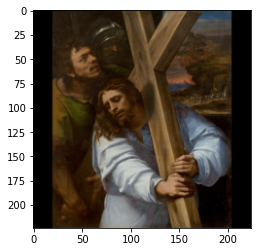

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(test_dataset[1][0].permute(1,2,0).numpy())

In [ ]:
%%time
y_train_indices = range(len(train_dataset))

y_train = [train_dataset[i][1] for i in y_train_indices]

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

CPU times: user 8min 37s, sys: 5.63 s, total: 8min 43s
Wall time: 8min 42s


In [ ]:
train_loader = DataLoader(dataset = train_dataset, shuffle=True, batch_size = 50)
test_loader = DataLoader(dataset = test_dataset, batch_size = 1)
val_loader = DataLoader(dataset = val_dataset, batch_size = 10)

In [ ]:
class ArtDLClassifier(nn.Module):
  def __init__(self, num_classes):
    super(ArtDLClassifier, self).__init__()
    # Loading the pretrained model
    self.resnet = models.resnet50(pretrained=True)

    self.stage1 = nn.Sequential(self.resnet.conv1, self.resnet.bn1, self.resnet.relu, self.resnet.maxpool,
                                    self.resnet.layer1)
    self.stage2 = nn.Sequential(self.resnet.layer2)
    self.stage3 = nn.Sequential(self.resnet.layer3)
    self.stage4 = nn.Sequential(self.resnet.layer4)

    self.avgpool = self.resnet.avgpool
    self.fc_conv = nn.Conv2d(in_channels = 2048, out_channels = num_classes, kernel_size=1)

    # Setting the trainable params for the optimizer
    self.tr_params = nn.ModuleList([self.stage1, self.stage2, self.stage3, self.stage4, self.avgpool, self.fc_conv])

    self.gradients = None

  #hook for the gradients of the activations
  def activations_hook(self, grad):
    self.gradients = grad

  def forward(self, image):
    # Forward prop
    out = self.stage1(image)
    out = self.stage2(out)
    out = self.stage3(out)
    h = out.register_hook(self.activations_hook)
    out = self.stage4(out)

    # h = out.register_hook(self.activations_hook) ##### If you want to get gradients at stage 4

    out = self.avgpool(out)
    
    out = self.fc_conv(out)
    return out

  def trainable_params(self):
    return (list(self.tr_params.parameters()))

  def get_activations_gradient(self):
        return self.gradients
    
  # method for the activation extraction
  def get_activations(self, x):
    out = self.stage1(x)
    out = self.stage2(out)
    return self.stage3(out)
    
    # return self.stage4(out)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
clf = ArtDLClassifier(num_classes = 19).to(device)
optimizer = optim.SGD(clf.trainable_params(), lr = 0.01, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
clf.load_state_dict(torch.load("/content/gdrive/MyDrive/ArtDl_Models/artDLresnet50_224x224_3.pt", map_location = device))

<All keys matched successfully>

In [ ]:
def train(epochs, model, train_loader, val_loader, optimizer, device, criterion):
  for epoch in range(epochs):
    # Setting the train mode
    model.train()
    train_loss = 0
    val_loss = 0
    for idx, (image, label) in enumerate(tqdm(train_loader)):
      image = image.to(device)
      label = label.to(device)

      # Zeroing the gradients before re-computing them
      optimizer.zero_grad()
      outputs = model(image).squeeze()
      
      # Calculating the loss
      loss = criterion(outputs, label)
      train_loss += loss.item()

      # Calculating the gradients == diff(loss w.r.t weights)
      loss.backward()

      # Updating the weights
      optimizer.step()
    
    model.eval()
    val_score = 0
    for idx, (image, label) in enumerate(val_loader):
      image = image.to(device)
      label = label.to(device)
      outputs = model(image).squeeze()

      # Getting the predictions
      pred = outputs.argmax(dim = 1, keepdim = True)

      # Updating scores and losses
      val_score += pred.eq(label.view_as(pred)).sum().item()
      loss = criterion(outputs, label)
      val_loss += loss.item()
    
    print("=================================================")
    print("Epoch: {}".format(epoch+1))
    print("Validation Loss: {}".format(val_loss/len(val_loader)))
    print("Training Loss: {}".format(train_loss/len(train_loader)))
    print(val_score)
    print("Validation Accuracy: {}".format((val_score)/len(val_loader)*10))

In [ ]:
train(3, clf, train_loader, val_loader, optimizer, device, criterion)

100%|██████████| 684/684 [11:42<00:00,  1.03s/it]


Epoch: 1
Validation Loss: 1.9015800128064047
Training Loss: 0.6868658170801157
2490
Validation Accuracy: 59.85576923076923


100%|██████████| 684/684 [11:17<00:00,  1.01it/s]


Epoch: 2
Validation Loss: 1.6244825213216245
Training Loss: 0.6082175230247933
2423
Validation Accuracy: 58.24519230769231


100%|██████████| 684/684 [11:11<00:00,  1.02it/s]


Epoch: 3
Validation Loss: 1.8685650418942363
Training Loss: 0.5425921683118009
2408
Validation Accuracy: 57.88461538461539


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
torch.save(clf.state_dict(), 'artDLresnet50_224x224.pt')

In [ ]:
!cp -r /content/artDLresnet50_224x224.pt /content/gdrive/MyDrive/ArtDl_Models/artDLresnet50_224x224_4.pt

In [ ]:
# clf.load_state_dict(torch.load("/content/gdrive/MyDrive/ArtDl_Models/artDLresnet50_224x224.pt", map_location = device))

<All keys matched successfully>

In [ ]:
def get_gradcam(model, image, label, size):
  label.backward()
  gradients = model.get_activations_gradient()

  pooled_gradients = torch.mean(gradients, dim=[0,2,3])
  activations = model.get_activations(image).detach()

  for i in range(activations.shape[1]):
    activations[:,i,:,:]*=pooled_gradients[i]
  print(activations.shape)
  heatmap=torch.mean(activations, dim=1).squeeze().cpu()
  heatmap = np.maximum(heatmap, 0)
  

  heatmap /= torch.max(heatmap)
  
  heatmap = cv2.resize(heatmap.numpy(), (size, size))
  return heatmap

In [ ]:
def plot_heatmap(denorm_image, actual, displaying, heatmap):

    fig, (ax1, ax2) = plt.subplots(figsize=(20,20), ncols=2)

    classes = ["MARY",
    "ANTONY ABBOT" ,
    "ANTONY OF PADUA",
    "AUGUSTINE",
    "DOMINIC",
    "FRANCIS",
    "JEROME",
    "JOHN THE BAPTIST",
    "JOHN",
    "JOSEPH",
    "PAUL",
    "PETER",
    "SEBASTIAN",
    "STEPHEN",
    "BARBARA",
    "CATHERINE",
    "MARY MAGDALENE",
    "John Baptist - Child",
    "John Baptist - Dead"
    ]

    print('Predicted class - ', classes[actual])
    print('Displaying for class - ', classes[displaying])
    ps = torch.nn.Softmax(dim = 1)(pred).cpu().detach().numpy()
    ax1.imshow(denorm_image)



    ax2.imshow(denorm_image)
    ax2.imshow(heatmap, cmap='magma', alpha=0.7)


1
torch.Size([1, 1024, 14, 14])
torch.Size([14, 14])
Actual class -  MARY
Displaying for class -  ANTONY ABBOT


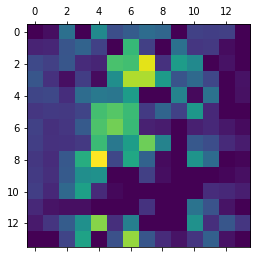

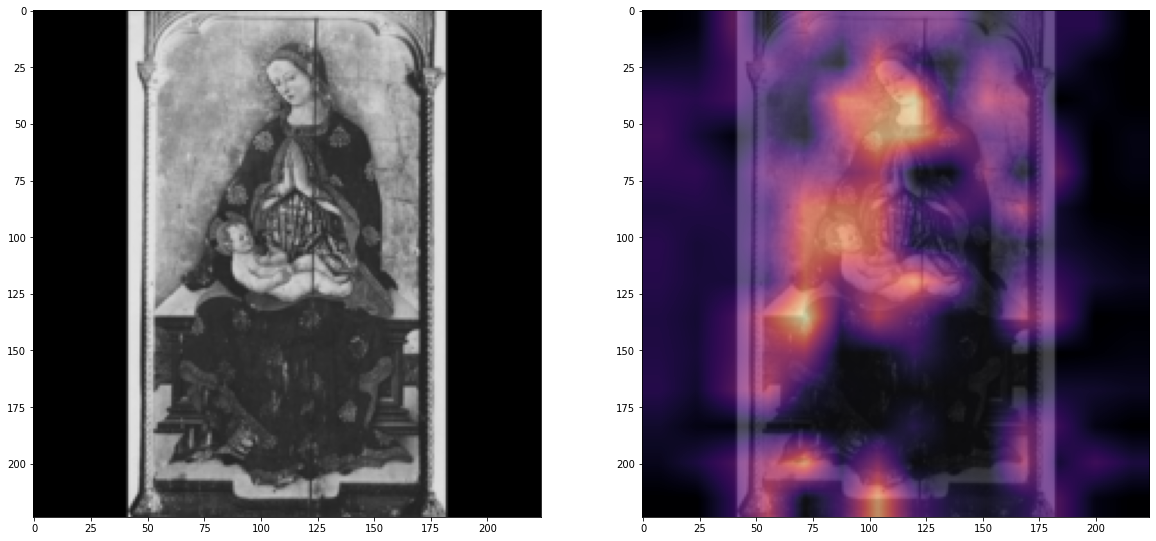

In [ ]:
image, label = val_dataset[6]
print(label)
denorm_image = image.permute(1, 2, 0)

image = image.unsqueeze(0).to(device)

pred = clf(image)
# print(pred)
heatmap = get_gradcam(clf, image, pred[0][1], size=224)

plot_heatmap(denorm_image, pred.argmax().cpu().detach().numpy(), 1, heatmap)

In [ ]:
pred.argmax().cpu().detach().numpy()


array(0)

In [ ]:
torch.nn.Softmax(dim = 1)(pred).cpu().detach().numpy()

array([[[[9.3771344e-01]],

        [[2.9581704e-04]],

        [[1.9029567e-04]],

        [[1.3792343e-03]],

        [[2.8559966e-03]],

        [[1.0062133e-02]],

        [[4.3593650e-03]],

        [[5.9594004e-03]],

        [[1.2277019e-02]],

        [[2.5571426e-03]],

        [[6.7649130e-03]],

        [[1.4715074e-03]],

        [[1.1998261e-03]],

        [[1.1222692e-03]],

        [[4.8322594e-03]],

        [[6.0751163e-03]],

        [[6.3209422e-04]],

        [[2.5101687e-04]],

        [[1.0134670e-06]]]], dtype=float32)

In [ ]:
pred

tensor([[[[ 6.1921]],

         [[-1.8694]],

         [[-2.3106]],

         [[-0.3299]],

         [[ 0.3980]],

         [[ 1.6574]],

         [[ 0.8209]],

         [[ 1.1336]],

         [[ 1.8563]],

         [[ 0.2875]],

         [[ 1.2604]],

         [[-0.2651]],

         [[-0.4692]],

         [[-0.5360]],

         [[ 0.9239]],

         [[ 1.1528]],

         [[-1.1101]],

         [[-2.0336]],

         [[-7.5458]]]], device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [ ]:
heatmap.shape

(224, 224)

In [ ]:
from torchsummary import summary

summary(clf, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
            Conv2d-3         [-1, 64, 112, 112]           9,408
       BatchNorm2d-4         [-1, 64, 112, 112]             128
       BatchNorm2d-5         [-1, 64, 112, 112]             128
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
              ReLU-8         [-1, 64, 112, 112]               0
              ReLU-9         [-1, 64, 112, 112]               0
        MaxPool2d-10           [-1, 64, 56, 56]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]           4,096
           Conv2d-14           [-1, 64,